In [512]:
#backtest setting

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import pykrx.stock as stock

In [513]:
#kospi1: 1998.12~1999.12 코스피가 저점대비 100%이상 상승
#kospi2: 2020.05~2021.05 현재 코로나 시국
kospi1 =  stock.get_market_ohlcv_by_date ( '19981201' ,  '19991201' ,  'kospi' ,  freq = 'd' )
kospi2 =  stock.get_market_ohlcv_by_date ( '20200501' ,  '20210505' ,  'kospi' ,  freq = 'd' )

In [514]:
#기준일 대비 얼마나 변했는지 확인. 
kospi1_change = (kospi1['종가']/kospi1['종가'].iloc[0]).reset_index()
kospi2_change = (kospi2['종가']/kospi2['종가'].iloc[0]).reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


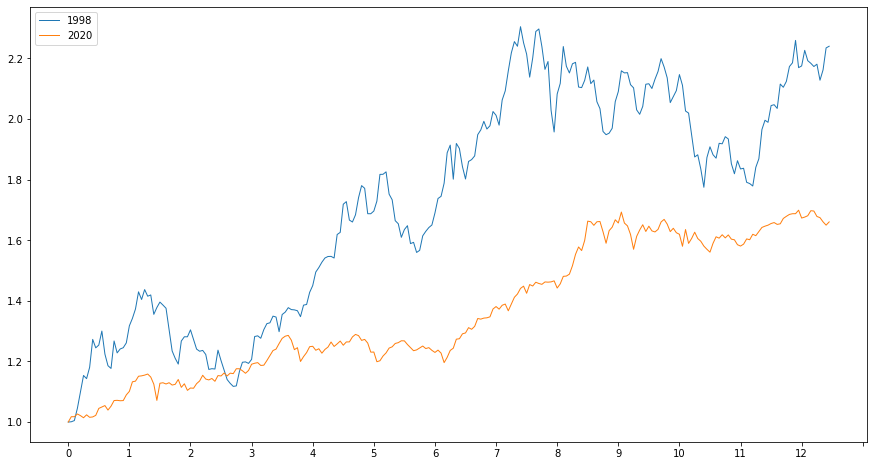

In [515]:
plt.figure(figsize = (15,8))
plt.plot(kospi1_change.index, kospi1_change['종가'], linewidth='1.',label='1998')
plt.plot(kospi1_change.index, kospi2_change['종가'], linewidth='1.',label='2020')
plt.legend(loc='upper left')
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(250//12))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(np.arange(-1,13)))

plt.show()

In [516]:
#백테스트에서 검증할 모멘텀과 베타
kospi = pd.read_excel('/workspace/AlgorithmTrading/1998-1999고슾히.xlsx', index_col=0)
beta = pd.read_excel('/workspace/AlgorithmTrading/1997-1998베타.xlsx', index_col=0)
price = pd.read_excel('/workspace/AlgorithmTrading/1998-1999종가.xlsx', index_col=0)
mom_price = pd.read_excel('/workspace/AlgorithmTrading/1997-1998종가.xlsx', index_col=0)

In [517]:
#1개월(영업일20일) 모멘텀 & 역추세
onemom = mom_price.pct_change(20)
one_trend = onemom.iloc[-1].sort_values(ascending=False)
one_trend_rev = onemom.iloc[-1].sort_values(ascending=True)

In [518]:
#3개월(영업일60일) 모멘텀 & 역추세
thrmom = mom_price.pct_change(60)
thr_trend = thrmom.iloc[-1].sort_values(ascending=False)
thr_trend_rev = thrmom.iloc[-1].sort_values(ascending=True)

In [519]:
#6개월(영업일120일) 모멘텀 & 역추세
sixmom = mom_price.pct_change(120)
six_trend = sixmom.iloc[-1].sort_values(ascending=False)
six_trend_rev = sixmom.iloc[-1].sort_values(ascending=True)

In [520]:
#low beta, high beta
low_beta = beta.sort_values(by='beta',ascending=True)
high_beta = beta.sort_values(by='beta',ascending=False)

In [521]:
# 시드머니 1억
# 동일가중
# 종목수 20, 50, 100개
# 동일가중 배분 함수 = (자산 비율) * (시드머니)
seed = 100_000_000
stock_count = [20, 50, 100]

def Same_alloc(seed, stock_cnt):
    alloc=[]
    stock_ratio=[]
    for i, cnt in enumerate(stock_cnt):
        stock_ratio=int(seed/stock_cnt[i])
        alloc.append([stock_ratio]*cnt)
    return alloc
allocs = Same_alloc(seed, stock_count)

In [522]:
#스크리닝 종목수:  20개 (stock_count)
#전략: 1개월 모멘텀
#보유 주식 수: 각 종목당 시드비중 // 매수할 때 주가 
#보유 주식 가격: 종가 * 보유 주식 수
#보유 주식 총 가치(가격 합)
#주식 사고 남은 현금: 시드 - 첫날 산 주식 총 가치
strategy = one_trend
screen_index = strategy.index[:len(allocs[0])]
screen_price = price[screen_index]
hold_cnt = allocs[0]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]

In [523]:
#총 자산 가치: 보유주식 + 남은 현금
#총 자산 변화: 총 자산 가치 / 시드
backtest = pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest['total_change']=backtest['total_value']/seed

In [524]:
#1MOM-50종목
strategy = one_trend
screen_index = strategy.index[:len(allocs[1])]
screen_price = price[screen_index]
hold_cnt = allocs[1]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest2 = pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest2['total_change']=backtest2['total_value']/seed

In [525]:
#1MOM-100종목
strategy = one_trend
screen_index = strategy.index[:len(allocs[2])]
screen_price = price[screen_index]
hold_cnt = allocs[2]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest3 = pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest3['total_change']=backtest3['total_value']/seed

In [526]:
#1MOM역추세-20종목
strategy = one_trend_rev
screen_index = strategy.index[:len(allocs[0])]
screen_price = price[screen_index]
hold_cnt = allocs[0]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest4= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest4['total_change']=backtest4['total_value']/seed

#1MOM역추세-50종목
strategy = one_trend_rev
screen_index = strategy.index[:len(allocs[1])]
screen_price = price[screen_index]
hold_cnt = allocs[1]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest5= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest5['total_change']=backtest5['total_value']/seed

#1MOM역추세-100종목
strategy = one_trend_rev
screen_index = strategy.index[:len(allocs[2])]
screen_price = price[screen_index]
hold_cnt = allocs[2]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest6= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest6['total_change']=backtest6['total_value']/seed


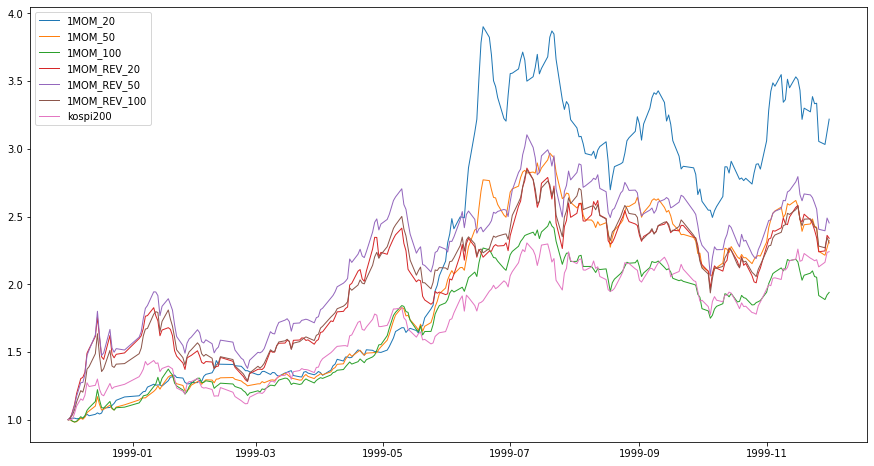

In [531]:
plt.figure(figsize =(15,8))
plt.plot(backtest.index, backtest['total_change'], linewidth='1.',label='1MOM_20')
plt.plot(backtest.index, backtest2['total_change'], linewidth='1.',label='1MOM_50')
plt.plot(backtest.index, backtest3['total_change'], linewidth='1.',label='1MOM_100')
plt.plot(backtest.index, backtest4['total_change'], linewidth='1.',label='1MOM_REV_20')
plt.plot(backtest.index, backtest5['total_change'], linewidth='1.',label='1MOM_REV_50')
plt.plot(backtest.index, backtest6['total_change'], linewidth='1.',label='1MOM_REV_100')
plt.plot(backtest.index, kospi1_change['종가'], linewidth='1.',label='kospi200')
plt.legend(loc='upper left')

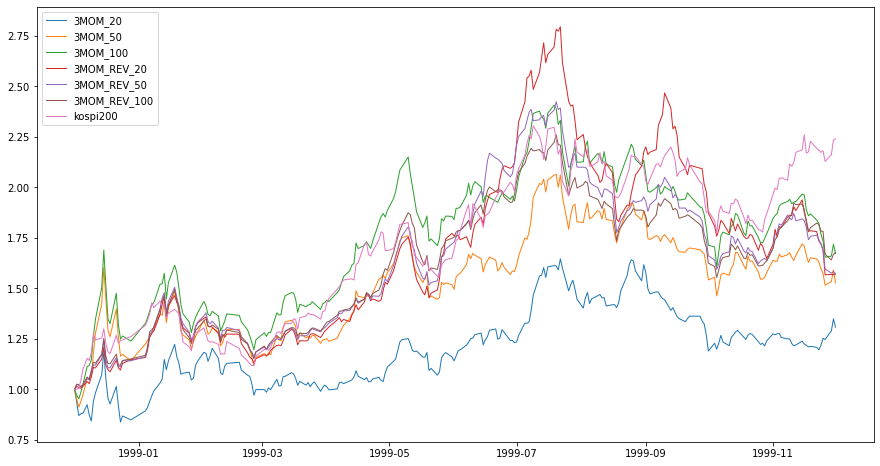

In [532]:
#3MOM-20종목
strategy = thr_trend
screen_index = strategy.index[:len(allocs[0])]
screen_price = price[screen_index]
hold_cnt = allocs[0]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest['total_change']=backtest['total_value']/seed

#3MOM-50종목
strategy = thr_trend
screen_index = strategy.index[:len(allocs[1])]
screen_price = price[screen_index]
hold_cnt = allocs[1]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest2= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest2['total_change']=backtest2['total_value']/seed

#3MOM-100종목
strategy = thr_trend
screen_index = strategy.index[:len(allocs[2])]
screen_price = price[screen_index]
hold_cnt = allocs[2]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest3= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest3['total_change']=backtest3['total_value']/seed


#3MOM역추세-20종목
strategy =thr_trend_rev
screen_index = strategy.index[:len(allocs[0])]
screen_price = price[screen_index]
hold_cnt = allocs[0]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest4= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest4['total_change']=backtest4['total_value']/seed

#3MOM역추세-50종목
strategy = thr_trend_rev
screen_index = strategy.index[:len(allocs[1])]
screen_price = price[screen_index]
hold_cnt = allocs[1]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest5= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest5['total_change']=backtest5['total_value']/seed

#3MOM역추세-100종목
strategy = thr_trend_rev
screen_index = strategy.index[:len(allocs[2])]
screen_price = price[screen_index]
hold_cnt = allocs[2]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest6= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest6['total_change']=backtest6['total_value']/seed

plt.figure(figsize =(15,8))
plt.plot(backtest.index, backtest['total_change'], linewidth='1.',label='3MOM_20')
plt.plot(backtest.index, backtest2['total_change'], linewidth='1.',label='3MOM_50')
plt.plot(backtest.index, backtest3['total_change'], linewidth='1.',label='3MOM_100')
plt.plot(backtest.index, backtest4['total_change'], linewidth='1.',label='3MOM_REV_20')
plt.plot(backtest.index, backtest5['total_change'], linewidth='1.',label='3MOM_REV_50')
plt.plot(backtest.index, backtest6['total_change'], linewidth='1.',label='3MOM_REV_100')
plt.plot(backtest.index, kospi1_change['종가'], linewidth='1.',label='kospi200')
plt.legend(loc='upper left')

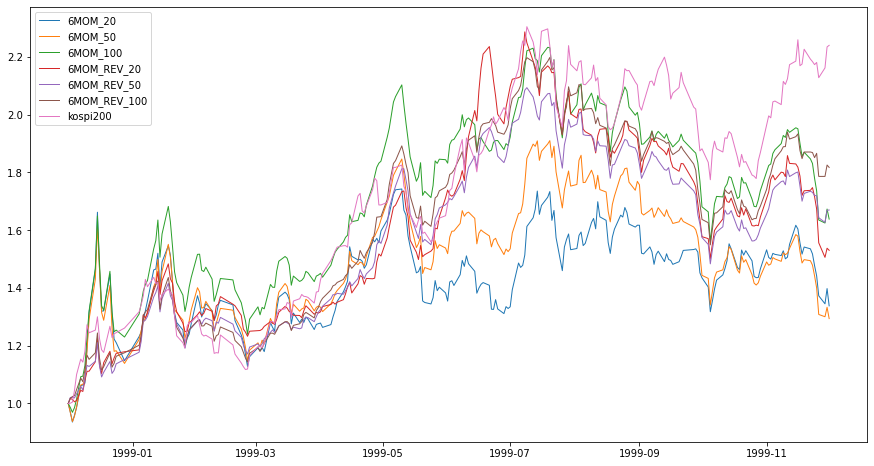

In [533]:
#6MOM-20종목
strategy = six_trend
screen_index = strategy.index[:len(allocs[0])]
screen_price = price[screen_index]
hold_cnt = allocs[0]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest['total_change']=backtest['total_value']/seed

#6MOM-50종목
strategy = six_trend
screen_index = strategy.index[:len(allocs[1])]
screen_price = price[screen_index]
hold_cnt = allocs[1]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest2= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest2['total_change']=backtest2['total_value']/seed

#6MOM-100종목
strategy = six_trend
screen_index = strategy.index[:len(allocs[2])]
screen_price = price[screen_index]
hold_cnt = allocs[2]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest3= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest3['total_change']=backtest3['total_value']/seed


#6MOM역추세-20종목
strategy =six_trend_rev
screen_index = strategy.index[:len(allocs[0])]
screen_price = price[screen_index]
hold_cnt = allocs[0]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest4= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest4['total_change']=backtest4['total_value']/seed

#6MOM역추세-50종목
strategy = six_trend_rev
screen_index = strategy.index[:len(allocs[1])]
screen_price = price[screen_index]
hold_cnt = allocs[1]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest5= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest5['total_change']=backtest5['total_value']/seed

#6MOM역추세-100종목
strategy = six_trend_rev
screen_index = strategy.index[:len(allocs[2])]
screen_price = price[screen_index]
hold_cnt = allocs[2]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest6= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest6['total_change']=backtest6['total_value']/seed

plt.figure(figsize =(15,8))
plt.plot(backtest.index, backtest['total_change'], linewidth='1.',label='6MOM_20')
plt.plot(backtest.index, backtest2['total_change'], linewidth='1.',label='6MOM_50')
plt.plot(backtest.index, backtest3['total_change'], linewidth='1.',label='6MOM_100')
plt.plot(backtest.index, backtest4['total_change'], linewidth='1.',label='6MOM_REV_20')
plt.plot(backtest.index, backtest5['total_change'], linewidth='1.',label='6MOM_REV_50')
plt.plot(backtest.index, backtest6['total_change'], linewidth='1.',label='6MOM_REV_100')
plt.plot(backtest.index, kospi1_change['종가'], linewidth='1.',label='kospi200')
plt.legend(loc='upper left')

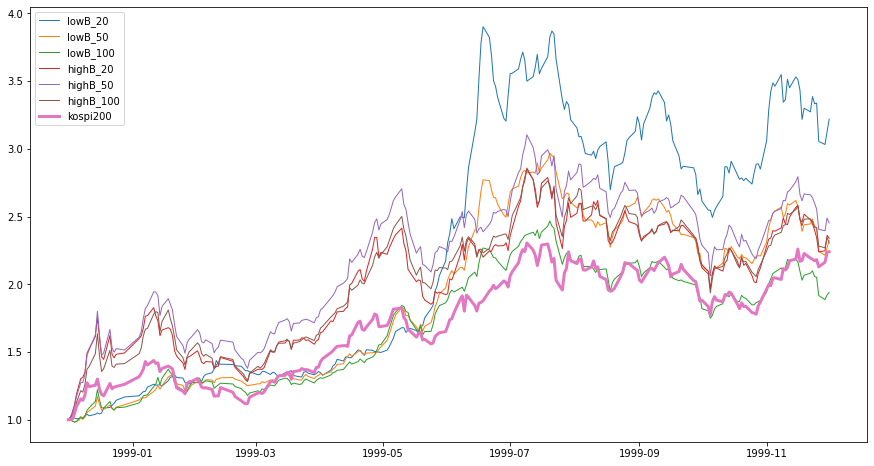

In [530]:
#Lowbeta-20종목
strategy = low_beta
screen_index = strategy.index[:len(allocs[0])]
screen_price = price[screen_index]
hold_cnt = allocs[0]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest['total_change']=backtest['total_value']/seed

#Lowbeta-50종목
strategy = low_beta
screen_index = strategy.index[:len(allocs[1])]
screen_price = price[screen_index]
hold_cnt = allocs[1]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest2= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest2['total_change']=backtest2['total_value']/seed

#Lowbeta-100종목
strategy = low_beta
screen_index = strategy.index[:len(allocs[2])]
screen_price = price[screen_index]
hold_cnt = allocs[2]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest3= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest3['total_change']=backtest3['total_value']/seed


#Highbeta-20종목
strategy = high_beta
screen_index = strategy.index[:len(allocs[0])]
screen_price = price[screen_index]
hold_cnt = allocs[0]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest4= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest4['total_change']=backtest4['total_value']/seed

#Highbeta-50종목
strategy = high_beta
screen_index = strategy.index[:len(allocs[1])]
screen_price = price[screen_index]
hold_cnt = allocs[1]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest5= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest5['total_change']=backtest5['total_value']/seed

#Highbeta-100종목
strategy = high_beta
screen_index = strategy.index[:len(allocs[2])]
screen_price = price[screen_index]
hold_cnt = allocs[2]//screen_price.loc['1998-12-01']
hold_price = screen_price * hold_cnt
hold_value = hold_price.sum(axis=1).astype(int)
rest = seed - hold_value.iloc[0]
backtest6= pd.DataFrame({'stock_value':hold_value,
                         'total_value':hold_value+rest,})
backtest6['total_change']=backtest6['total_value']/seed

plt.figure(figsize =(15,8))
plt.plot(backtest.index, backtest['total_change'], linewidth='1.',label='lowB_20')
plt.plot(backtest.index, backtest2['total_change'], linewidth='1.',label='lowB_50')
plt.plot(backtest.index, backtest3['total_change'], linewidth='1.',label='lowB_100')
plt.plot(backtest.index, backtest4['total_change'], linewidth='1.',label='highB_20')
plt.plot(backtest.index, backtest5['total_change'], linewidth='1.',label='highB_50')
plt.plot(backtest.index, backtest6['total_change'], linewidth='1.',label='highB_100')
plt.plot(backtest.index, kospi1_change['종가'], linewidth='3.',label='kospi200')
plt.legend(loc='upper left')

In [535]:
e = pd.read_excel('/workspace/AlgorithmTrading/운용종목산업명.xlsx', index_col=0)

In [536]:
e

""
회사명
